### DATA PREPROCESSING

In [90]:
%reload_ext autoreload
%autoreload 2

# imports
import os
import ast
import math
import json
import requests
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import ipywidgets as widgets

import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


from scipy import stats
from datetime import datetime as dt
from ipywidgets import interact, interactive, fixed, interact_manual

from IPython.display import HTML
from statsmodels.stats.multicomp import pairwise_tukeyhsd


from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

import nltk


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [91]:
import helpers

# Data Loading , the imprt_movies_data function load and preprocess the data
movies,characters, plot_summaries = helpers.import_movies_data("./data/")


movies.shape

(24660, 13)

### GENRE

(883,)
 "/m/07s9rl0": "Drama"              5432
 "/m/01z4y": "Comedy"               2936
{"/m/01jfsb": "Thriller"            2454
 "/m/01z4y": "Comedy"}              2208
 "/m/07s9rl0": "Drama"}             2153
                                    ... 
 "/m/02rcm2r": "Sponsored film"}       1
{"/m/0b7z1vt": "Road-Horror"}          1
 "/m/0b7z1vt": "Road-Horror"           1
 "/m/0fx2s": "Tragedy"}                1
 "/m/02fcct": "Clay animation"}        1
Length: 883, dtype: int64


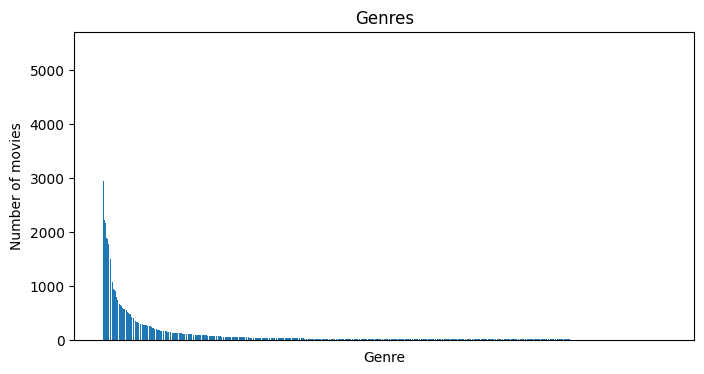

In [92]:
#genres
genres = movies["movie_genres"].str.split(",", expand=True).stack().value_counts()
print(genres.shape)
print(genres)
#plot genres
plt.figure(figsize=(8, 4))
plt.bar(genres.index, genres.values)
#hide x labels
plt.xticks([])
#plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()

In [93]:
#extract the main genre
def extract_genres(row):
    try:
        genres_dict = json.loads(row)
        return list(genres_dict.values()) if genres_dict else ['NaN']
    except json.JSONDecodeError:
        return ['NaN']

# Apply the function to create a new 'genre' column
movies['genre'] = movies['movie_genres'].apply(extract_genres)
genre=movies['genre'].explode().copy()
genre=genre[genre!='NaN']
genre=genre.value_counts()
#find the unique genres
unique_genres = genre.index
print(unique_genres)

Index(['Drama', 'Comedy', 'Romance Film', 'Black-and-white', 'Thriller',
       'Action', 'Crime Fiction', 'Short Film', 'Indie', 'Adventure',
       ...
       'Children's Issues', 'Space opera', 'Star vehicle', 'Comdedy',
       'Period Horror', 'Film-Opera', 'Private military company',
       'Prison escape', 'Nuclear warfare', 'Clay animation'],
      dtype='object', length=339)


In [94]:
# give the top 10 genres that has the largerst number of movies and store them in genre_main
genre_main = genre[:10]
print(genre_main.shape)
print(genre_main.index)

(10,)
Index(['Drama', 'Comedy', 'Romance Film', 'Black-and-white', 'Thriller',
       'Action', 'Crime Fiction', 'Short Film', 'Indie', 'Adventure'],
      dtype='object')


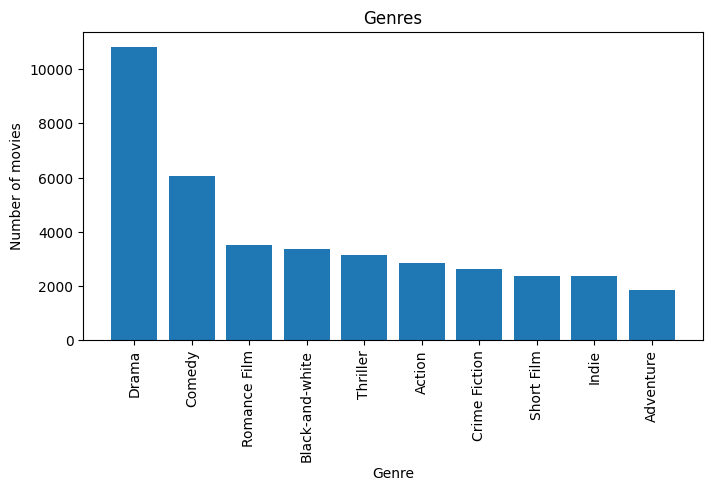

In [95]:
#plot the top 10 genres
plt.figure(figsize=(8, 4))
plt.bar(genre_main.index, genre_main.values)
plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()


In [96]:
#filter the movies that have the genres in genre_main, not necessarily the first genre
movies_main = movies[movies['genre'].apply(lambda x: any(item for item in x if item in genre_main.index))].copy()
print(movies_main.shape)
movies_main.head()


(20826, 14)


,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,tconst,averageRating,numVotes,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0228333,4.9,56928.0,"[Thriller, Science Fiction, Horror, Adventure,..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,tt0094806,5.6,41.0,"[Crime Fiction, Drama]"
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,tt0002894,6.8,17.0,"[Short Film, Silent film, Indie, Black-and-whi..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,tt0029852,6.8,2268.0,"[Musical, Comedy, Black-and-white]"
10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1930,tt0021335,5.4,300.0,"[Drama, Black-and-white]"


(10,)
Index(['Drama', 'Comedy', 'Romance Film', 'Black-and-white', 'Thriller',
       'Action', 'Crime Fiction', 'Short Film', 'Indie', 'Adventure'],
      dtype='object')


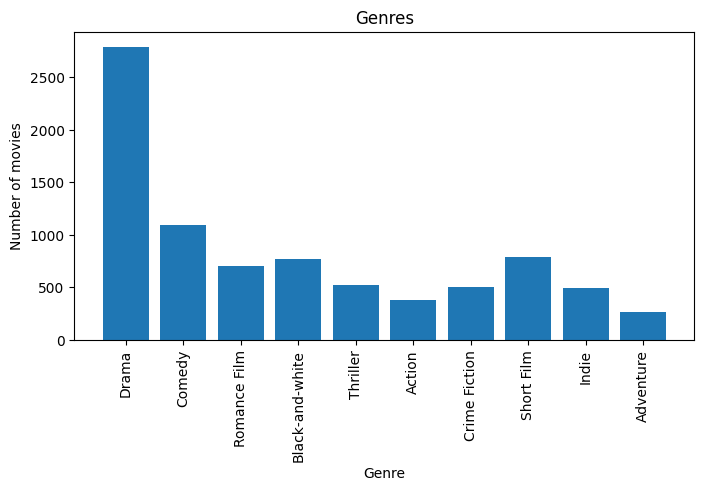

In [97]:
#filter the movies with rating higher than 7 from the movies_main dataset
movies_main_filtered= movies_main[movies_main['averageRating']>=7].copy()
#for each genre in genre_main, find the number of movies in movies_main_filter that have the genre
#and plot the number of movies for each genre
genre_main_filtered = movies_main_filtered['genre'].explode().value_counts()[genre_main.index]
print(genre_main_filtered.shape)
print(genre_main_filtered.index)
plt.figure(figsize=(8, 4))
plt.bar(genre_main_filtered.index, genre_main_filtered.values)
plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()

In [98]:
# now let's look into the combination of genres
# generate a list of all the combinations of the top 10 genres without repetition
genre_combinations = []
for i in range(len(genre_main.index)):
    for j in range(i+1, len(genre_main.index)):
        genre_combinations.append(genre_main.index[i] + ',' + genre_main.index[j])
print(len(genre_combinations))

45


(10, 2)


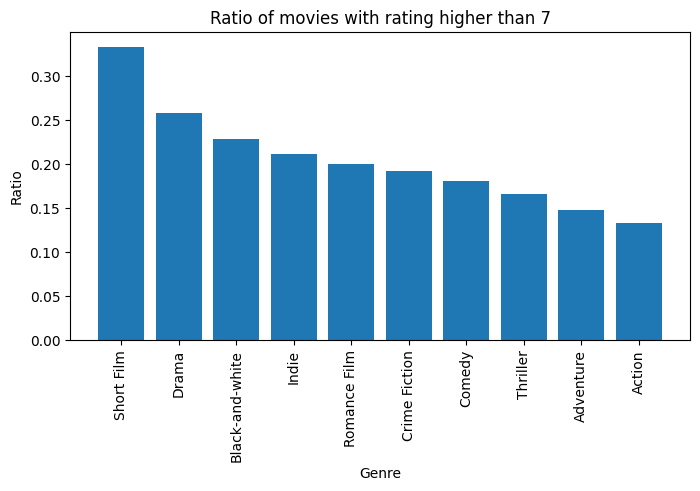

In [99]:
#for each genre, calculate the ratio of movies with rating higher than 7 / total number of movies in that genre
genre_ratio = pd.DataFrame(columns=['genre', 'ratio'])
for g in genre_main.index:
    ratio = len(movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: g in x)]) / len(movies_main[movies_main['genre'].apply(lambda x: g in x)])
    #add the genre and ratio to the dataframe
    genre_ratio = pd.concat([genre_ratio, pd.DataFrame({'genre': [g], 'ratio': [ratio]})], ignore_index=True)#sort the dataframe by ratio
genre_ratio = genre_ratio.sort_values(by='ratio', ascending=False)
print(genre_ratio.shape)
#plot the ratio
plt.figure(figsize=(8, 4))
plt.bar(genre_ratio['genre'], genre_ratio['ratio'])
plt.xticks(rotation=90)
plt.title("Ratio of movies with rating higher than 7")
plt.xlabel("Genre")
plt.ylabel("Ratio")
plt.show()


In [100]:
#create a new dataframe with only the top 10 genres and has a rating larger than 7
movies_main = movies[movies["averageRating"] >= 7].copy()
movies_main = movies_main.reset_index(drop=True)
print(movies_main.shape)
movies_main.head()

(5730, 14)


,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,tconst,averageRating,numVotes,genre
0,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,tt0097499,7.5,31208.0,"[Costume drama, War film, Epic, Period piece, ..."
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,tt0058331,7.8,181829.0,"[Children's/Family, Musical, Fantasy, Comedy, ..."
2,32456683,/m/0gyryjt,Die Fahne von Kriwoj Rog,1967,NaN,108.0,"{""/m/04306rv"": ""German Language""}","{""/m/03f2w"": ""German Democratic Republic""}",{},1967,tt0061637,7.6,23.0,[NaN]
3,9633533,/m/02pml15,Vandanam,1989,NaN,168.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}",1989,tt0255668,7.9,1260.0,[Action]
4,2487170,/m/07h9zj,Troops,1997,NaN,10.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/068twy"": ""Fan film"", ""/m/02hmvc"": ""Short ...",1997,tt0153301,7.7,2625.0,"[Fan film, Short Film, Indie]"


In [101]:
# plot the number of movies for a genre for each decade
def plot_decade_genre(genre):
    # create a new dataframe with only the genre
    movies_genre = movies_main[movies_main['genre'].apply(lambda x: genre in x)].copy()
    # create a new column with the decade
    movies_genre['decade'] = movies_genre['year_released'].apply(lambda x: int(x) // 10 * 10)
    # create a new dataframe with the number of movies for each decade
    movies_genre_decade = movies_genre['decade'].value_counts().sort_index()
    # plot the number of movies for each decade
    plt.figure(figsize=(8, 4))
    plt.bar(movies_genre_decade.index, movies_genre_decade.values)
    plt.title("Number of movies for each decade")
    plt.xlabel("Decade")
    plt.ylabel("Number of movies")
    plt.show()

# apply the function to the top 10 genres
interact(plot_decade_genre, genre=genre_main.index,sharey=True)

interactive(children=(Dropdown(description='genre', options=('Drama', 'Comedy', 'Romance Film', 'Black-and-whi…

<function __main__.plot_decade_genre(genre)>

In [102]:
# now we explore the combination of genres
# plot the number of movies for each combination of genres of the top 10 genres in each decade
plt.figure(figsize=(8, 4))
def plot_genre_combination_decade(genre1, genre2):
    # create a new dataframe with only the two genres
    movies_genre = movies_main[movies_main['genre'].apply(lambda x: genre1 in x and genre2 in x)].copy()
    # create a new column with the decade
    movies_genre['decade'] = movies_genre['year_released'].apply(lambda x: int(x) // 10 * 10)
    # create a new dataframe with the number of movies for each decade
    movies_genre_decade = movies_genre['decade'].value_counts().sort_index()
    # plot the number of movies for each decade

    plt.bar(movies_genre_decade.index, movies_genre_decade.values)
    plt.title("Number of movies for each decade of genre")
    plt.xlabel("Decade")
    plt.ylabel("Number of movies")
    plt.show()


# apply the function to the top 10 genres
interact(plot_genre_combination_decade, genre1=genre_main.index, genre2=genre_main.index)

<Figure size 800x400 with 0 Axes>

interactive(children=(Dropdown(description='genre1', options=('Drama', 'Comedy', 'Romance Film', 'Black-and-wh…

<function __main__.plot_genre_combination_decade(genre1, genre2)>

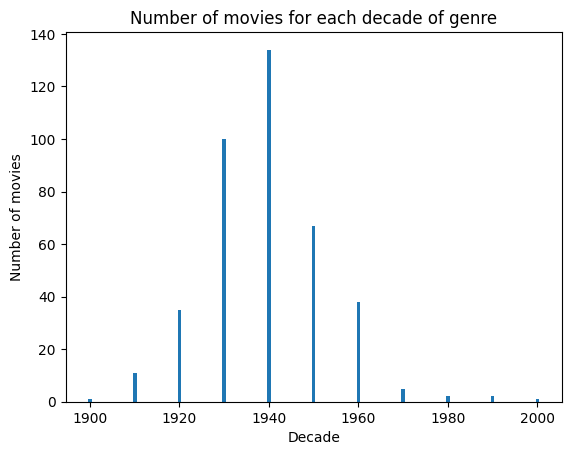

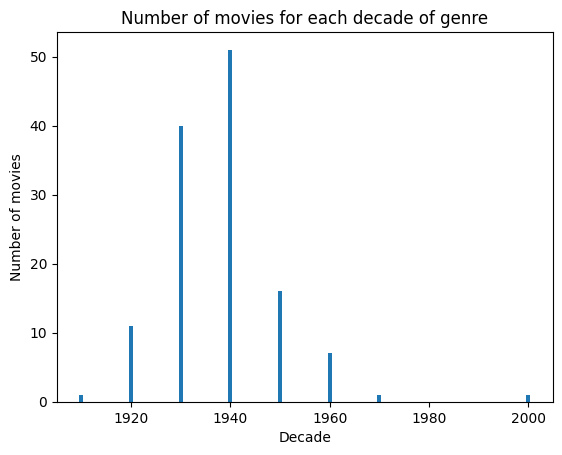

In [103]:
plot_genre_combination_decade('Drama', 'Black-and-white')
plot_genre_combination_decade('Romance Film', 'Black-and-white')

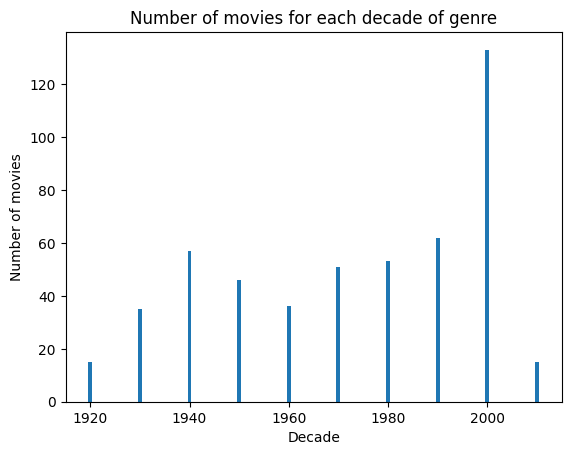

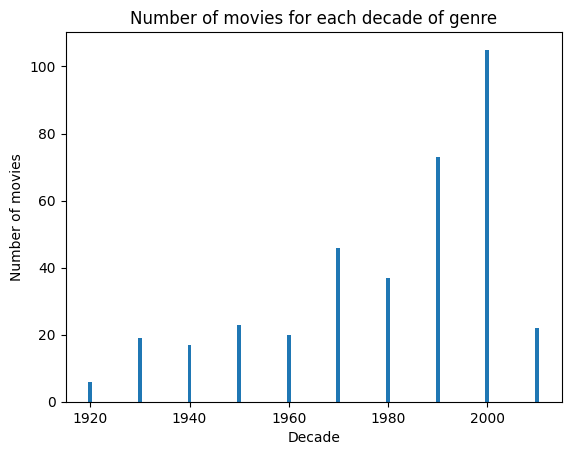

In [104]:
plot_genre_combination_decade('Drama', 'Romance Film')
plot_genre_combination_decade('Drama', 'Comedy')

In [105]:
# now lets focus on the years after 2000
# create a new dataframe with only the movies after 2000
movies_2000 = movies_main[(movies_main['year_released'] >= 2000)].copy()
# do the above analysis for every year in the decade
def plot_genre_combination_year(genre1,genre2):
    # create a new dataframe with only the two genres
    movies_genre = movies_2000[movies_2000['genre'].apply(lambda x: genre1 in x and genre2 in x)].copy()
    # create a new dataframe with the number of movies for each year
    movies_genre_year = movies_genre['year_released'].value_counts().sort_index()
    # plot the number of movies for each decade
    plt.figure(figsize=(8, 4))
    plt.bar(movies_genre_year.index, movies_genre_year.values)
    plt.title("Number of movies for each year after 2000")
    plt.xlabel("Decade")
    plt.ylabel("Number of movies")
    plt.show()

# apply the function to the top 10 genres
interact(plot_genre_combination_year, genre1=genre_main.index, genre2=genre_main.index)

interactive(children=(Dropdown(description='genre1', options=('Drama', 'Comedy', 'Romance Film', 'Black-and-wh…

<function __main__.plot_genre_combination_year(genre1, genre2)>

In [106]:
#duration
#the distribution of runtime and its correlation with rating
print(movies[["movie_runtime", "averageRating"]].count())
duration = movies[["movie_runtime", "averageRating"]].dropna()
duration.count()

movie_runtime    22978
averageRating    24660
dtype: int64


movie_runtime    22978
averageRating    22978
dtype: int64

### DURATION

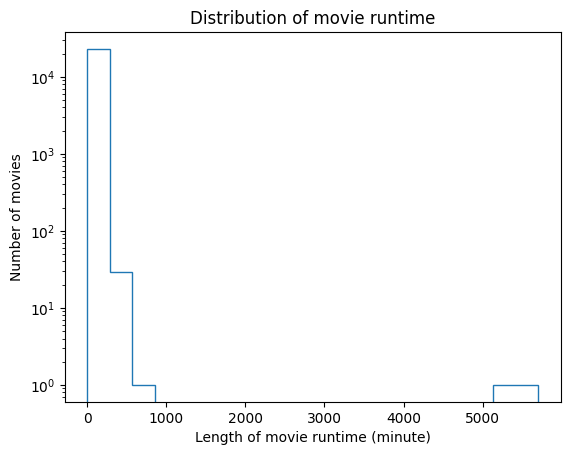

In [107]:
# histogram plot without removing outliers
plt.hist(duration["movie_runtime"], histtype="step", log=True, bins=20)
plt.title("Distribution of movie runtime")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Number of movies")
plt.show()


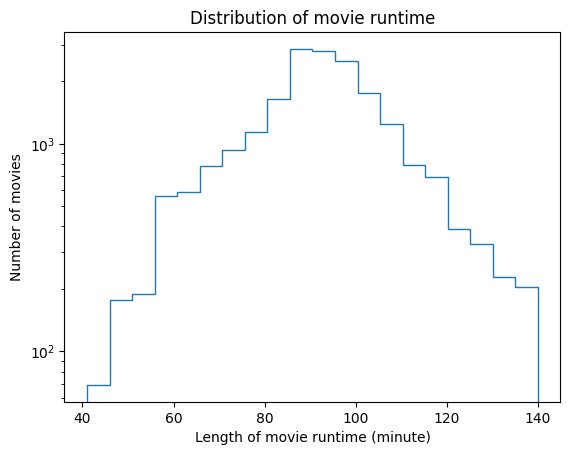

In [108]:
# histogram plot with removing outliers using IQR
q1 = duration["movie_runtime"].quantile(0.25)
q3 = duration["movie_runtime"].quantile(0.75)
iqr = q3 - q1
duration = duration[duration["movie_runtime"] < q3 + 1.5 * iqr]
duration = duration[duration["movie_runtime"] > q1 - 1.5 * iqr]

plt.hist(duration["movie_runtime"], histtype="step", log=True, bins=20)
plt.title("Distribution of movie runtime")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Number of movies")
plt.show()


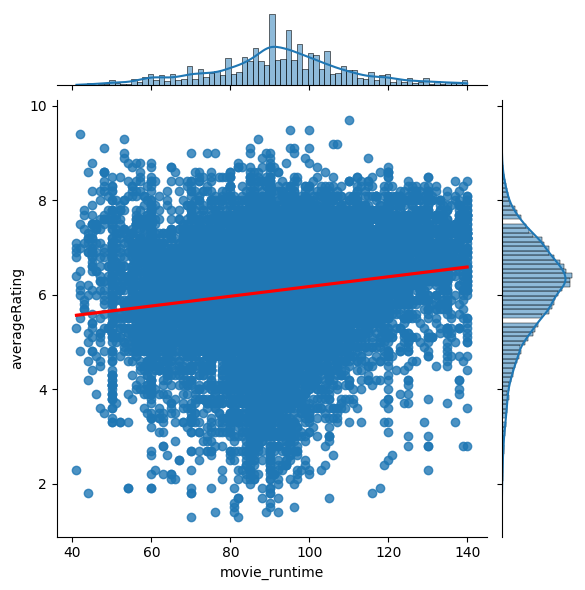

In [109]:
# use sns to plot the scatter plot of runtime and rating with regression line
sns.jointplot(x="movie_runtime", y="averageRating", data=duration, kind="reg",line_kws={"color": "red"})

In [110]:
#perform linear regression on duration data, and plot the regression line
model=smf.ols(formula='averageRating ~ movie_runtime', data=duration)
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     583.6
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          4.12e-127
Time:                        19:28:58   Log-Likelihood:                -29342.
No. Observations:               19883   AIC:                         5.869e+04
Df Residuals:                   19881   BIC:                         5.870e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.1441      0.040    128.177

In [111]:
#filter the movies with rating higher than 7 from the movies_main dataset
movies_high_rating= duration[duration['averageRating']>=7].copy()
movies_non_high_rating= duration[duration['averageRating']<7].copy()
print(movies_high_rating.shape)
print(movies_non_high_rating.shape)


(4039, 2)
(15844, 2)


In [112]:
#perform a t-test on the runtime of movies with rating higher than 7 and movies with rating lower than 7 to see if there is a significant difference
stats.ttest_ind(a=movies_high_rating["movie_runtime"], b=movies_non_high_rating["movie_runtime"],equal_var=False)

TtestResult(statistic=18.23649492976614, pvalue=3.3081771240684825e-72, df=5542.015771121735)

In [113]:
#calculate the mean of runtime for movies with rating higher than 7 and movies with rating lower than 7 and their difference
print(movies_high_rating["movie_runtime"].mean())
print(movies_non_high_rating["movie_runtime"].mean())
diff=movies_high_rating["movie_runtime"].mean()-movies_non_high_rating["movie_runtime"].mean()
print(f"The mean difference in duration is:{diff}")

#calculate the percentage of difference
perc=diff/movies_non_high_rating["movie_runtime"].mean()*100
print(f"The percentage difference in duration is:{perc}")

97.3040356523892
91.06652360515021
The mean difference in duration is:6.237512047238994
The percentage difference in duration is:6.849401734367112


In [114]:
#split the movies into two groups, one with movie_runtime>=80 and the other with movie_runtime<80
movies_long_duration=duration[duration["movie_runtime"]>=80]
movies_short_duration=duration[duration["movie_runtime"]<80]

In [115]:
#perform a t-test on the rating of movies with runtime>=80 and movies with runtime<80 to see if there is a significant difference
stats.ttest_ind(a=movies_long_duration["averageRating"], b=movies_short_duration["averageRating"],equal_var=False)

TtestResult(statistic=6.399199090977577, pvalue=1.6753856230556606e-10, df=6241.166588683542)

In [116]:
#calculate the mean of rating for movies with runtime>=80 and movies with runtime<80 and their difference
print(movies_long_duration["averageRating"].mean())
print(movies_short_duration["averageRating"].mean())
diff=movies_long_duration["averageRating"].mean()-movies_short_duration["averageRating"].mean()
print(f"The mean difference in rating is:{diff}")

#calculate the percentage of difference
perc=diff/movies_short_duration["averageRating"].mean()*100
print(f"The percentage difference in rating is:{perc}")


6.120770635270414
6.00045
The mean difference in rating is:0.12032063527041448
The percentage difference in rating is:2.0051935316587004


(10, 2)


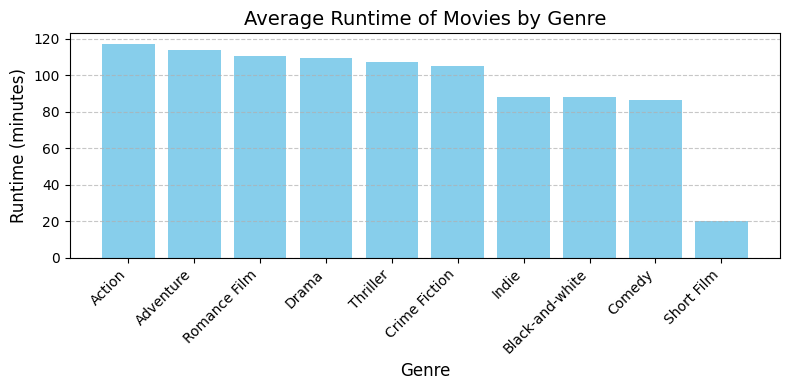

In [117]:
#for each genre, calculate the average of movies runtime
genre_runtime = pd.DataFrame(columns=['genre', 'runtime'])
for g in genre_main.index:
    #calculate runtime
    runtime = movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: g in x)]['movie_runtime'].mean()
    #add the genre and runtime to the dataframe
    genre_runtime = pd.concat([genre_runtime, pd.DataFrame({'genre': [g], 'runtime': [runtime]})], ignore_index=True)
#sort the dataframe by runtime
genre_runtime = genre_runtime.sort_values(by='runtime', ascending=False)
print(genre_runtime.shape)

# Plotting the runtime of movies by genre
plt.figure(figsize=(8, 4))

# Bar plot
plt.bar(genre_runtime['genre'], genre_runtime['runtime'], color='skyblue')

# Adjusting plot aesthetics
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Average Runtime of Movies by Genre", fontsize=14)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Runtime (minutes)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


### TOPIC DETECTION

In [118]:
plot_summaries.head()

,MovieID,PlotSummary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


After defining the most "liked" genres according to the most ranked movies, we will proceed with the topic analysis among these movies (the most ranked). 
Thus, we will define the most liked topic in each top 5 most liked genres. 

In [119]:


nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
nltk.download('punkt')  
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Lowercasing
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Tokenization and Lemmatization
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 3]
    return tokens

# Apply preprocessing to each PlotSummary
#plot_summaries['processed_plot'] = plot_summaries['PlotSummary'].apply(preprocess)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [120]:
# movies that have drama as one of their genres
drama_movies = movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: 'Drama' in x)].copy()
# from plot_summaries dataset, extract the plot summaries of the drama movies
drama_movies_plot = plot_summaries[plot_summaries['MovieID'].isin(drama_movies['wikipedia_movie_ID'])].copy()

# movies that have comedy as one of their genres
comedy_movies = movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: 'Comedy' in x)].copy()
# from plot_summaries dataset, extract the plot summaries of the comedy movies
comedy_movies_plot = plot_summaries[plot_summaries['MovieID'].isin(comedy_movies['wikipedia_movie_ID'])].copy()

# movies that have short film as one of their genres
short_movies = movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: 'Short Film' in x)].copy()

# from plot_summaries dataset, extract the plot summaries of the short movies
short_movies_plot = plot_summaries[plot_summaries['MovieID'].isin(short_movies['wikipedia_movie_ID'])].copy()

# movies that have Black-and-white as one of their genres
bw_movies = movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: 'Black-and-white' in x)].copy()
# from plot_summaries dataset, extract the plot summaries of the Black-and-white movies
bw_movies_plot = plot_summaries[plot_summaries['MovieID'].isin(bw_movies['wikipedia_movie_ID'])].copy()

# movies that have Romance film as one of their genres
romance_movies = movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: 'Romance Film' in x)].copy()
# from plot_summaries dataset, extract the plot summaries of the Romance movies
romance_movies_plot = plot_summaries[plot_summaries['MovieID'].isin(romance_movies['wikipedia_movie_ID'])].copy()




In [121]:
#preprocess the plot summaries of the drama movies and store them in drama_movies_plot['processed_plot']
drama_movies_plot['processed_plot'] = drama_movies_plot['PlotSummary'].apply(preprocess)

# Create a dictionary representation of the documents
dictionary_drama = Dictionary(drama_movies_plot['processed_plot'])

# Filter out words that occur less than 5 documents, or more than 90% of the documents.
dictionary_drama.filter_extremes(no_below=5, no_above=0.95)

# Create a bag-of-words representation of the documents
corpus_drama = [dictionary_drama.doc2bow(doc) for doc in drama_movies_plot['processed_plot']]

In [122]:
#preprocess the plot summaries of the comedy movies and store them in comedy_movies_plot['processed_plot']
comedy_movies_plot['processed_plot'] = comedy_movies_plot['PlotSummary'].apply(preprocess)

#create a dictionary representation of the documents
dictionary_comedy = Dictionary(comedy_movies_plot['processed_plot'])

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary_comedy.filter_extremes(no_below=5, no_above=0.9)

# Create a bag-of-words representation of the documents
corpus_comedy = [dictionary_comedy.doc2bow(doc) for doc in comedy_movies_plot['processed_plot']]

In [123]:
#preprocess the plot summaries of the short movies and store them in short_movies_plot['processed_plot']
short_movies_plot['processed_plot'] = short_movies_plot['PlotSummary'].apply(preprocess)


#create a dictionary representation of the documents
dictionary_short = Dictionary(short_movies_plot['processed_plot'])

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary_short.filter_extremes(no_below=5, no_above=0.9)

# Create a bag-of-words representation of the documents
corpus_short = [dictionary_short.doc2bow(doc) for doc in short_movies_plot['processed_plot']]


In [124]:
#preprocess the plot summaries of the Black-and-white movies and store them in bw_movies_plot['processed_plot']
bw_movies_plot['processed_plot'] = bw_movies_plot['PlotSummary'].apply(preprocess)

#create a dictionary representation of the documents
dictionary_bw = Dictionary(bw_movies_plot['processed_plot'])

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary_bw.filter_extremes(no_below=5, no_above=0.9)

# Create a bag-of-words representation of the documents
corpus_bw = [dictionary_bw.doc2bow(doc) for doc in bw_movies_plot['processed_plot']]

In [125]:
#preprocess the plot summaries of the Romance movies and store them in romance_movies_plot['processed_plot']
romance_movies_plot['processed_plot'] = romance_movies_plot['PlotSummary'].apply(preprocess)

#create a dictionary representation of the documents
dictionary_romance = Dictionary(romance_movies_plot['processed_plot'])

# Filter out words that occur less than 5 documents, or more than 50% of the documents.
dictionary_romance.filter_extremes(no_below=5, no_above=0.9)

# Create a bag-of-words representation of the documents
corpus_romance = [dictionary_romance.doc2bow(doc) for doc in romance_movies_plot['processed_plot']]



We will be performing the LDA algorithm for topic analysis.

In [143]:
# Set training parameters
num_topics = 3 # Adjust the number of topics
passes = 20     # Adjust the number of passes
genres=['Drama', 'Comedy', 'Short-film', 'Black-and-white', 'Romance-film']
dictionary = [dictionary_drama, dictionary_comedy, dictionary_short, dictionary_bw, dictionary_romance]

# Initialize counters for each genre
genre_topic_counts = {genre: [0] * num_topics for genre in genres}


for index_corpus, corpus in enumerate([corpus_drama, corpus_comedy, corpus_short, corpus_bw, corpus_romance] ):
    

    # Train the LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary[index_corpus], num_topics=num_topics, passes=passes, 
                                        minimum_probability=0.03,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           alpha='auto', # symmetric, asymmetric
                                           per_word_topics=True)
    
    print(f"Genre: {genres[index_corpus]}")
    # Print the Keyword in the topics   
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic: {idx} \nWords: {topic}")
        
    # Count the number of movies per topic
    for doc in corpus:
        topics = lda_model.get_document_topics(doc)
        for topic_num, prop_topic in topics:
            if prop_topic > 0.3:  # Threshold for topic dominance in a document
                genre_topic_counts[genres[index_corpus]][topic_num] += 1

# Print the counts for each topic in each genre
for genre, counts in genre_topic_counts.items():
    for topic_num, count in enumerate(counts):
        print(f"{genre}, Topic {topic_num}: {count} movies")



Genre: Drama
Topic: 0 
Words: 0.008*"life" + 0.007*"love" + 0.006*"family" + 0.006*"father" + 0.006*"tell" + 0.006*"find" + 0.006*"mother" + 0.006*"take" + 0.006*"home" + 0.006*"friend"
Topic: 1 
Words: 0.010*"police" + 0.006*"kill" + 0.005*"find" + 0.005*"money" + 0.005*"murder" + 0.004*"take" + 0.004*"tell" + 0.004*"charlie" + 0.004*"back" + 0.004*"gang"
Topic: 2 
Words: 0.008*"film" + 0.005*"american" + 0.004*"ship" + 0.004*"order" + 0.004*"king" + 0.004*"state" + 0.004*"soldier" + 0.003*"first" + 0.003*"captain" + 0.003*"group"
Genre: Comedy
Topic: 0 
Words: 0.007*"tell" + 0.007*"love" + 0.007*"friend" + 0.006*"find" + 0.006*"home" + 0.006*"life" + 0.006*"father" + 0.006*"take" + 0.005*"time" + 0.005*"school"
Topic: 1 
Words: 0.008*"film" + 0.005*"show" + 0.005*"police" + 0.005*"find" + 0.005*"money" + 0.004*"back" + 0.004*"henry" + 0.004*"return" + 0.004*"life" + 0.003*"take"
Topic: 2 
Words: 0.009*"jack" + 0.007*"back" + 0.007*"time" + 0.007*"road" + 0.006*"attempt" + 0.006*"esca

We are here interpreting the results that the LDA algorithm gave us:



### Drama
1. **Family and Personal Struggles**: This topic focuses on themes like life, love, family dynamics, and personal challenges. It often involves characters dealing with complex relationships and emotional journeys.
2. **Crime and Conflict**: This topic is centered around police, crime, murder, and gang-related activities. It often includes elements of suspense, betrayal, and moral dilemmas.
3. **Historical and Political Drama**: Involving films with themes like war, leadership, and national issues. It may include movies about historical figures, soldiers, and significant political or social events.

### Comedy
1. **Romantic and Family Comedy**: This topic deals with love, friendship, and social life. It often includes humorous takes on relationships, family, and everyday situations.
2. **Dark Comedy**: Includes comedic films that may parody other genres or societal norms. It involves elements like police, money, and life's absurdities.
3. **Adventurous and Escapades**: Focuses on characters like Jack and themes of adventure, road trips, and escapades, often with humorous undertones.

### Short Film
1. **Adult Films**: This topic is about short films that focus on storytelling and character development, often involving personal tales and life experiences.
2. **Animated Classics and Characters**: Centers on classic animated characters like Ralph, Sylvester, Tweety, and the Pink Panther, often involving comedic and adventurous plots.
3. **Adventurous and Escapades**: Involves characters in constant motion, like Wile E. Coyote and Road Runner, featuring physical comedy and slapstick elements.

### Black-and-White
1. **Classic Storytelling**: Involves traditional narrative structures with elements of suspense, resolution, and often a moral lesson.
2. **Character-Centric Tales**: Focuses on personal stories and relationships, often involving a journey or transformation of the main characters like Mary or Tramp.
3. **Family and Life Journeys**: Deals with themes of love, life, home, and the passage of time, often exploring deep emotional and relational aspects.

### Romance Film
1. **Modern Love and Relationships**: This topic explores contemporary romantic relationships, often set in urban environments and involving themes of love, career, and personal growth.
2. **Royal and Aristocratic Romance**: Involves stories about royalty and aristocracy, with characters like kings, princes, and their romantic and political intrigues.
3. **Family Romance**: Centers on timeless themes of love and life, often involving family dynamics, personal discovery, and the evolution of relationships over time.



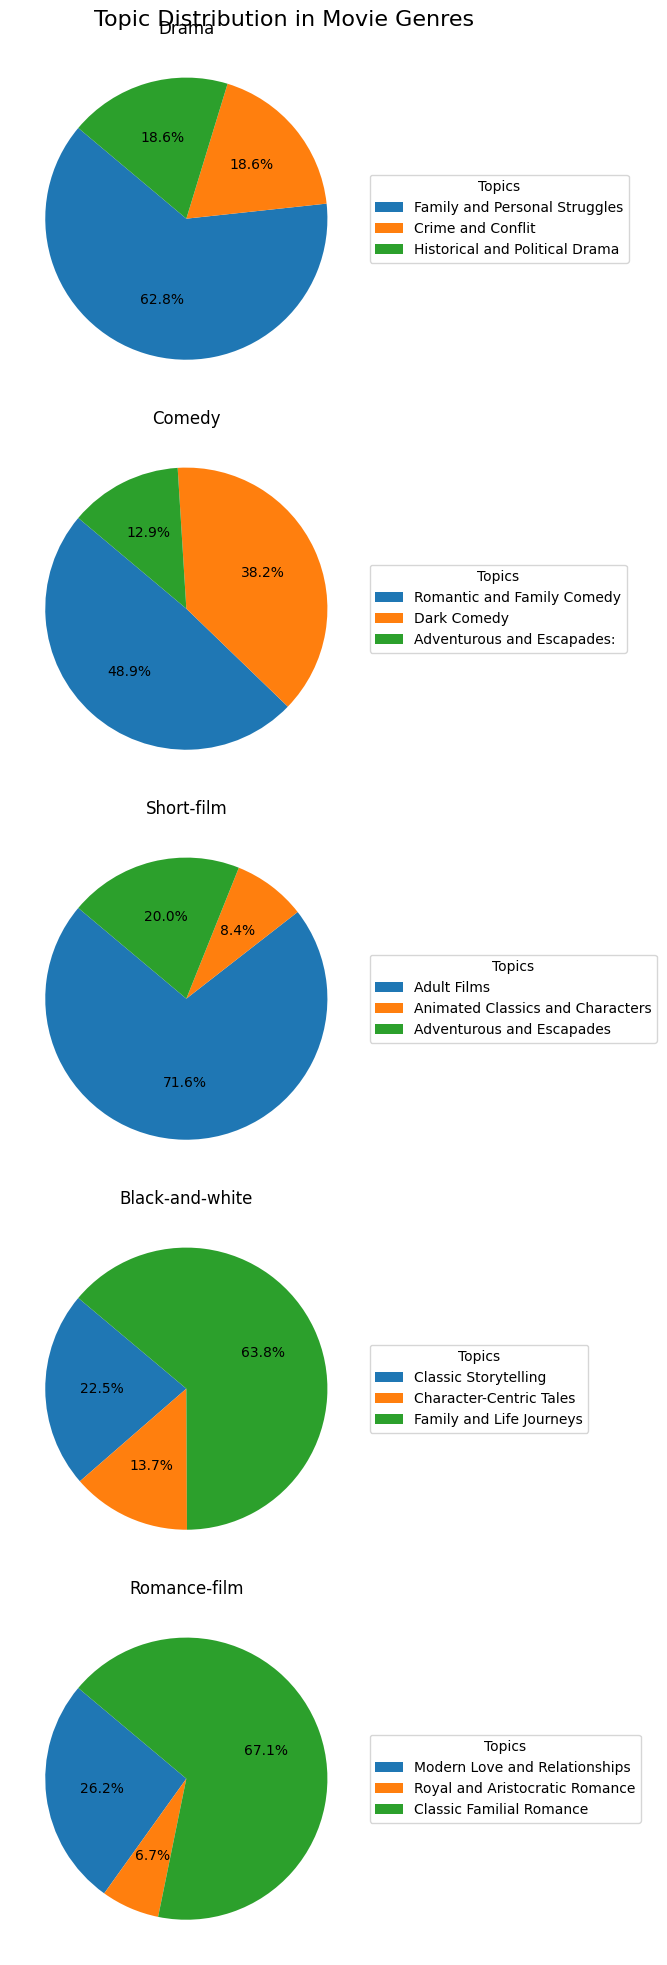

In [145]:
topics = {"Drama": ["Family and Personal Struggles", "Crime and Conflit", "Historical and Political Drama"],
            "Comedy": ["Romantic and Family Comedy", "Dark Comedy", "Adventurous and Escapades:"],
            "Short-film": ["Adult Films", "Animated Classics and Characters", "Adventurous and Escapades"],
            "Black-and-white": ["Classic Storytelling", "Character-Centric Tales", "Family and Life Journeys"],
            "Romance-film": ["Modern Love and Relationships", "Royal and Aristocratic Romance", "Classic Familial Romance"]}


# Plotting the pie charts in a vertical layout
fig, axes = plt.subplots(5, 1, figsize=(6, 20))  # Adjusted layout to vertical and size
fig.suptitle('Topic Distribution in Movie Genres', fontsize=16)

for i, (genre, counts) in enumerate(genre_topic_counts.items()):
    wedges, texts, autotexts = axes[i].pie(counts, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(genre)
    axes[i].legend(wedges, topics[genre], title="Topics", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()


We notice that the family topic is common within all the genres with a significant percentage. This suggests that the family tocpic might have an influcence with the good ranking of movies, therefore might be within the most appreciated topics by the film public.